# Fashion sales

<p>1- In this file, we start by cleaning and preparing our fashion sales timeserie from 2017 to 2021</p> 
<p>2- Then we carry out an exploratory analysis and visualize the data to understand it.</p>
<p>3- Next, we propose guidelines for building a sales forecasting model from our data.  </p>
<p>4- At the end, we present our idea for a data model to set up a multidimensional report/dashboard when sales data is terrabyte in size.</p>


In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller



## Data Cleaning and Preparing

#### collect data

In [3]:

data= pd.read_csv('sales.csv')
data.head()

,Date,Product_ID,Store_ID,Promotion_Flag,Discount_percent,Price,Sold_Units,Sales_Volume
0,2017-01-01,P1_,S7_,NaN,NaN,75.0,0.0,0.0
1,2017-01-02,P1_,S7_,NaN,NaN,75.0,0.0,0.0
2,2017-01-03,P1_,S7_,NaN,NaN,75.0,0.0,0.0
3,2017-01-04,P1_,S7_,NaN,NaN,75.0,0.0,0.0
4,2017-01-05,P1_,S7_,NaN,NaN,75.0,0.0,0.0


#### handel empty values

In [4]:
data.columns

Index(['Date', 'Product_ID', 'Store_ID', 'Promotion_Flag',
       ' Discount_percent ', 'Price', 'Sold_Units', 'Sales_Volume'],
      dtype='object')

##### handel null or no row for Date

In [5]:
# check for null values in columns
data.isnull().sum()

Date                   1749
Product_ID             1749
Store_ID               1749
Promotion_Flag        20043
 Discount_percent     20043
Price                  1749
Sold_Units             1749
Sales_Volume           1749
dtype: int64

In [6]:
# remove rows with null values for Date column
data.dropna(subset=['Date'], inplace=True)

In [7]:
data.isnull().sum()

Date                      0
Product_ID                0
Store_ID                  0
Promotion_Flag        18294
 Discount_percent     18294
Price                     0
Sold_Units                0
Sales_Volume              0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19992 entries, 0 to 21740
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                19992 non-null  object 
 1   Product_ID          19992 non-null  object 
 2   Store_ID            19992 non-null  object 
 3   Promotion_Flag      1698 non-null   float64
 4    Discount_percent   1698 non-null   float64
 5   Price               19992 non-null  float64
 6   Sold_Units          19992 non-null  float64
 7   Sales_Volume        19992 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.4+ MB


In [9]:
data['Date'] = pd.to_datetime(data['Date'])

In [10]:
# sort data by Date
data = data.sort_values(by='Date').reset_index(drop=True)

##### check for missing dates rows

In [11]:

# Generate expected range of dates
expected_dates = pd.date_range(start=data['Date'].min(), end=data['Date'].max(), freq='D')

# Compare expected dates to actual dates in the DataFrame
missing_dates = expected_dates[~expected_dates.isin(data['Date'])]

# Check if there are missing dates
if len(missing_dates) > 0:
    print("Missing dates:")
    print(missing_dates)
else:
    print("No missing dates.")


No missing dates.


##### Handel missing value for column Promotion_Flag and Discount_percent

In [12]:
# rename column ' Discount_percent ' to remove empty space
data.rename(columns={' Discount_percent ': 'Discount_percent'}, inplace=True)

In [13]:
# for column promotion_flag and discount percent replace null value with 0. 
data.fillna({'Promotion_Flag': 0}, inplace=True)
data.fillna({'Discount_percent': 0}, inplace=True)


In [14]:
data.isnull().sum()

Date                0
Product_ID          0
Store_ID            0
Promotion_Flag      0
Discount_percent    0
Price               0
Sold_Units          0
Sales_Volume        0
dtype: int64

In [15]:
# create column date_datetime
# data['Date'] = pd.to_datetime(data['Date'])

#### Prepare data: create features column that help for visualation and forcasting model

In [16]:
# add column year, month, day

# Create new columns for year, month, and day
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['weekday'] = data['Date'].dt.day_name()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19992 entries, 0 to 19991
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              19992 non-null  datetime64[ns]
 1   Product_ID        19992 non-null  object        
 2   Store_ID          19992 non-null  object        
 3   Promotion_Flag    19992 non-null  float64       
 4   Discount_percent  19992 non-null  float64       
 5   Price             19992 non-null  float64       
 6   Sold_Units        19992 non-null  float64       
 7   Sales_Volume      19992 non-null  float64       
 8   year              19992 non-null  int32         
 9   month             19992 non-null  int32         
 10  day               19992 non-null  int32         
 11  weekday           19992 non-null  object        
dtypes: datetime64[ns](1), float64(5), int32(3), object(3)
memory usage: 1.6+ MB


##  Data Analyse with visualisation

In [18]:
# split data in differents size

dfs_by_year = {}

# Iterate over years from 2017 to 2021
for year in range(2017, 2022):
    # Filter DataFrame for the current year
    dfs_by_year[year] = data[data['Date'].dt.year == year]

# Access each DataFrame for each year
df_2017 = dfs_by_year[2017]
df_2018 = dfs_by_year[2018]
df_2019 = dfs_by_year[2019]
df_2020 = dfs_by_year[2020]
df_2021 = dfs_by_year[2021]


In [19]:
# datatrame from 2017 to 2020
data_filtered = data[data['year'] != 2021]

In [20]:
# plot all time series

# Create traces for each time series
trace1 = go.Scatter(x=df_2017['Date'], y=df_2017['Sales_Volume'], mode='lines', name='2017')
trace2 = go.Scatter(x=df_2018['Date'], y=df_2018['Sales_Volume'], mode='lines', name='2018')
trace3 = go.Scatter(x=df_2019['Date'], y=df_2019['Sales_Volume'], mode='lines', name='2019')
trace4 = go.Scatter(x=df_2020['Date'], y=df_2020['Sales_Volume'], mode='lines', name='2020')
#trace5 = go.Scatter(x=df_2021['Date'], y=df_2021['Sales_Volume'], mode='lines', name='2021')

# Create a figure and add traces
fig = make_subplots(rows=4, cols=1, subplot_titles=('2017', '2018', '2019', '2020'))

fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=2, col=1)
fig.add_trace(trace3, row=3, col=1)
fig.add_trace(trace4, row=4, col=1)
#fig.add_trace(trace5, row=5, col=1)

# # Update figure layout
# fig.update_layout(title='Three Time Series',
#                   xaxis_title='Date',
#                   yaxis_title='sales')

# Update layout
fig.update_layout(height=600, width=800, title_text="Graph1: Sales on all years")


# Show the plot
fig.show()

This graph present the sales timeseries on 2027...2020. We can observe the same trend every year. Sales increase significantly between the end and the beginning of the year. And in mid-year, there's a lighter increase in sales.

In [21]:
fig = px.bar(data_filtered, x="month", y="Sales_Volume", barmode= 'group', title='Graph2: total sales per month between 2017 to 2020') 
fig.show()

In [22]:
input_year = 2018
fig = px.bar(dfs_by_year[2017], x="month", y="Sales_Volume", barmode= 'group', title='Graph3: total sales per month on ' + str(input_year)) 
fig.show()

<p>These last two graphs reveal more precisely the distribution of sales over each month for all years for graph 2, and for a selected year for graph 3.</p> 
<p>January and December are the months with the highest sales in each year. May and June follow. From 2017
to 2020, there is a difference of almost 2.5 million between December and January sales and May and June sales.
</p>
<p> for next sections, we caraterise period frm december and january as sales period 1 and the period of mai and june as sales period 2. </p>

In [23]:
fig = px.pie(data, values='Sales_Volume', names='Product_ID', title='Graph4: Proportion of product sold between 2017 to 2021')
fig.show()

In [24]:
input_year = 2020

fig = px.pie(dfs_by_year[input_year], values='Sales_Volume', names='Product_ID', 
            title='Graph 5: Proportion of product sold in ' + str(input_year))

fig.show()

<p>Charts 4 and 5 show the products and their sales proportions between 2017 and 2010 for chart 4, and in a selected year for chart 5.</p> 

<p>The best-selling products every year are ProductID 12( “Ladies‘ business blouse - white”) and ProductID 11: (“Ladies’ pants - dark blue - size 36”). These are followed by ProductID 6( "HUGO BOSS Business Shirt - white - 44/45") and ProductID 3 ("Thermal pants - Regular Fit - LYCRA"). </p>

<p>The lowest-selling products are ID 8 “Shirt - light blue - size S” and ID 9 “Skirt - dark blue - size M”.
</p>



In [25]:
productID = 'P10_'

df  = data_filtered[data_filtered['Product_ID'] == productID]

fig = px.bar(df, x="month", y="Sales_Volume", 
        title='Graph 6: Total sales of product '+ str(productID) + ' between 2017 to 2020') 
fig.show()

In [26]:
input_year = 2020
productID = 'P5_'

df = dfs_by_year[input_year]
df  = df[df['Product_ID'] == productID]
fig = px.bar(df, x="month", y="Sales_Volume", barmode= 'group', title='Graph 7: total sales of the product '+ str(productID) + ' by month in ' + str(input_year)) 
fig.show()

<p>Graph 6 and 7 show the distribution of sales of a product for each month chosen between 2017 and 2020 for 6 and a selected year.</p>

<p>From these graphs, we can see that top-selling products such as P12, P11 and P6 sell a lot almost constantly throughout the year. Prodcut P5 has also a constant sale behavior. <p>

<p>Other products are only sold during one sales period. Products P1,P2,P7,P8 are sold during sales period 2 and products P3,P4,P9,P10 are sold during sales period 1.<p>


Date                0
Product_ID          0
Store_ID            0
Promotion_Flag      0
Discount_percent    0
Price               0
Sold_Units          0
Sales_Volume        0
dtype: int64

In [27]:
# check the inlfuence on product price on the sales or sold_unit

# Define the bin edges for unit prices
bin_edges = np.arange(data_filtered['Price'].min(), data_filtered['Price'].max() + 10, 10)

# Bin the unit prices into ranges and calculate aggregate sold units for each range

datacopie = data_filtered
datacopie['price_range'] = pd.cut(data_filtered['Price'], bins=bin_edges)
agg_sold_units = data_filtered.groupby('price_range')['Sold_Units'].sum()
agg_Sale = data_filtered.groupby('price_range')['Sales_Volume'].sum()

C:\Users\mariu\AppData\Local\Temp\ipykernel_19064\675310574.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mariu\AppData\Local\Temp\ipykernel_19064\675310574.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\mariu\AppData\Local\Temp\ipykernel_19064\675310574.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [28]:
agg_Sale.head(7)

price_range
(35.0, 45.0]      9801072.0
(45.0, 55.0]     13111461.0
(55.0, 65.0]     13416286.0
(65.0, 75.0]      7203820.5
(75.0, 85.0]      2729096.0
(85.0, 95.0]      5531859.5
(95.0, 105.0]    12818553.6
Name: Sales_Volume, dtype: float64

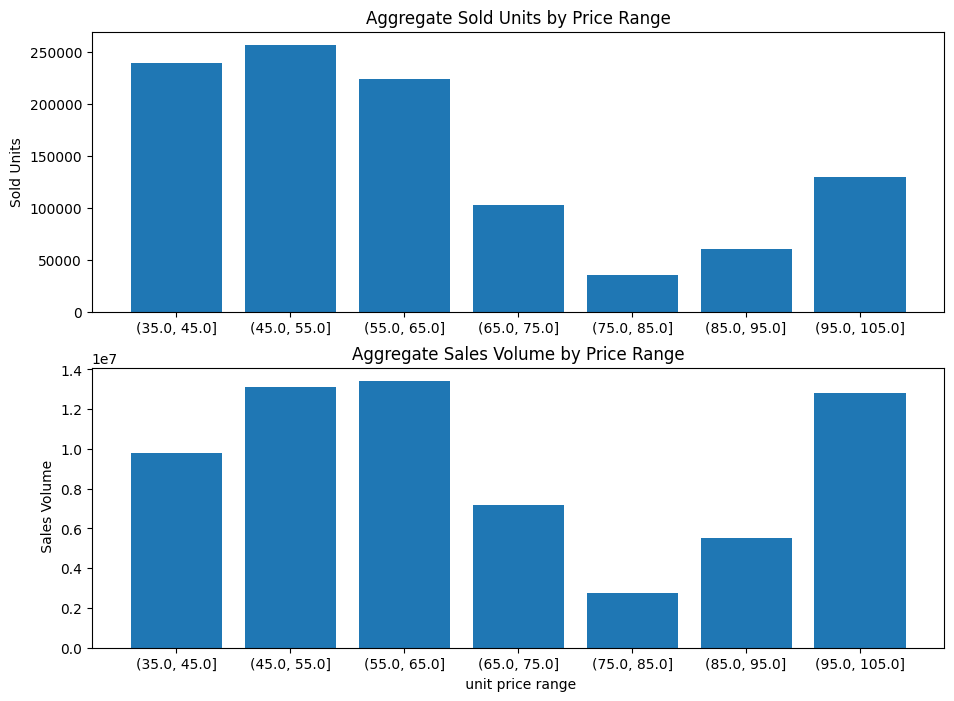

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 8))
ax[0].bar(agg_sold_units.index.astype(str), agg_sold_units)
ax[1].bar(agg_sold_units.index.astype(str), agg_Sale)

ax[0].set_title('Aggregate Sold Units by Price Range')
ax[0].set_ylabel('Sold Units')

ax[1].set_title('Aggregate Sales Volume by Price Range')
ax[1].set_ylabel(' Sales Volume')
ax[1].set_xlabel(' unit price range')


plt.show()




<p>In this graph, the plot above shows the number of product units sold in each unit price range. The graph below shows the sales volume at each unit price range. It is based on data from 2017 to 2020.</p> 
<p>It can be seen here that unit prices between 45 and 65 have the highest number of units sold and the highest sales volumes.</p> 
<p>On the other hand, very high unit prices between 95 and 105 do not have the highest number of units sold, but do have one of the highest sales volumes. </p>
<p>Products with relatively average unit prices, between 75 and 95, have a low number of units sold and low sales volumes compared with the other ranges. </p>

In [30]:
'''

fig = px.box(data_filtered, x='weekday', y='Sales_Volume', color='Promotion_Flag', 
             category_orders={"weekday": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]},
             labels={"Sales_Volume": "Sales_Volume", "Promotion_Flag": "Promotion"},
             title='Distribution of Sales on Different Weekdays with and without Promotion')

# Update layout
fig.update_layout(xaxis_title='Weekday', yaxis_title='Sales')

# Show the plot
fig.show()

'''

'\n\nfig = px.box(data_filtered, x=\'weekday\', y=\'Sales_Volume\', color=\'Promotion_Flag\', \n             category_orders={"weekday": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]},\n             labels={"Sales_Volume": "Sales_Volume", "Promotion_Flag": "Promotion"},\n             title=\'Distribution of Sales on Different Weekdays with and without Promotion\')\n\n# Update layout\nfig.update_layout(xaxis_title=\'Weekday\', yaxis_title=\'Sales\')\n\n# Show the plot\nfig.show()\n\n'

In [31]:
'''
fig = px.box(data_filtered, x='Promotion_Flag', y='Sales_Volume', color='Promotion_Flag', 
             #category_orders={"weekday": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]},
             #labels={"Sales_Volume": "Sales_Volume", "Promotion_Flag": "Promotion"},
             title='Distribution of Sales with and without Promotion')

# Update layout
fig.update_layout(xaxis_title='promotion', yaxis_title='Sales_Volume')

# Show the plot
fig.show()

'''

'\nfig = px.box(data_filtered, x=\'Promotion_Flag\', y=\'Sales_Volume\', color=\'Promotion_Flag\', \n             #category_orders={"weekday": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]},\n             #labels={"Sales_Volume": "Sales_Volume", "Promotion_Flag": "Promotion"},\n             title=\'Distribution of Sales with and without Promotion\')\n\n# Update layout\nfig.update_layout(xaxis_title=\'promotion\', yaxis_title=\'Sales_Volume\')\n\n# Show the plot\nfig.show()\n\n'

#### Check the stationarity
machine learning model assume that time serie are stationary(no seasonality, no trend). Statistical properties(mean, variance) more or less, same over the time.
We have to check if our time series are stationary. But with Graph1, we can already make assuption about non-stationary of our time serie. We can observe almost the same trend on each year(period of one year).
We can ue Null-Hypothese test to test the stionarity. F

ADF test: test for stationary

- Null Hypothesis: The series has a unit root.(that means serie is non stationary)
- Alternate Hypothesis: The series has no unit root. (that means serie is stationary)

- p-value >= 0.05: Fail to reject the null hypothesis (H0), the serie is non-stationary.
- p-value < 0.05: Reject the null hypothesis (H0), the serie is stationary


In [32]:
# test stationarity


result = adfuller(data_filtered['Sales_Volume'].values)


In [33]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.594659
p-value: 0.094106
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


 the p_value > 0,05 => Test fail to reject the Null-Hypothese. Time serie may be non-stationary. 

KPSS Test to test  trend stationary

- Null Hypothesis: series is trend stationary.

- Alternate Hypothesis: The series has a unit root (series is not stationary).

- if p_value >= 0.05 => fail to reject the Null-Hypothese => serie is trend stationary 
- if p_value < 0.05 => reject the Null-Hypothese => serie is not stationary


In [34]:
result = kpss(data_filtered['Sales_Volume'].values, regression='ct')

In [35]:
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('lag used: %f' % result[2])
print('Critical Values:')
for key, value in result[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.188520
p-value: 0.020305
lag used: 61.000000
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


p-value < 0.05 => reject the null-hypothesis => serie is not stationary.

For forcasting model, we need to make our time serie first stationary.

In [36]:
# decompose our time serie to visualise tends by a period of one year
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['Sales_Volume'], period= 360)


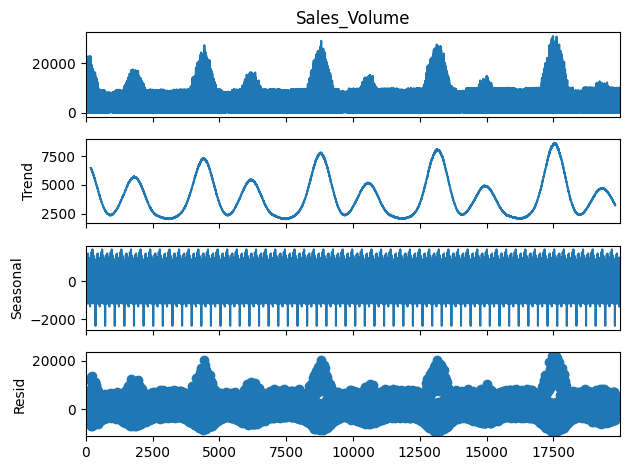

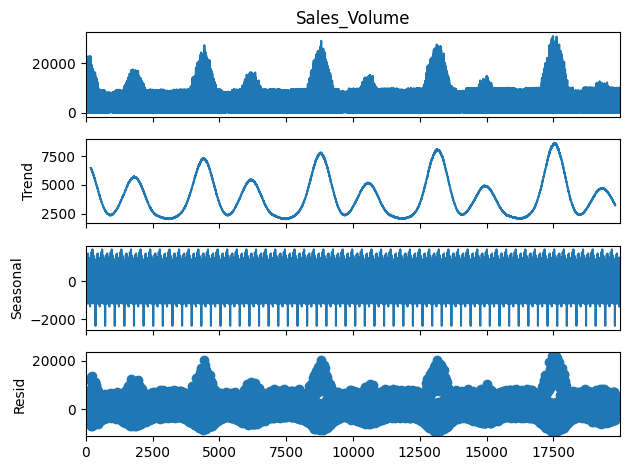

In [37]:
decomposition.plot()

## Guidelines for building a sales forecasting model



<p> There are many models available from the fields of statistics and machine learning for forecasting time series. There is no one model that dominates all others in performance for every time series. To find out which is the best model for a time series use case, we can train and evaluate several models and choose the best one for our data. We can also use ensemble or stacking models.</p>

<p>We should note that there are some specific steps depending on the model used. For example, feature generation for RandomForest is not the same as for LSTM (an RNN model).</p> 

<p>Here are the forecasting steps:</p>

<p>1- check for stationary: Model work well or can predict better if the statistic properties almost the same </p>

<p>2- Make Serie stationary if necessary: If the time series ares not make it stationary, convert it in  stationary one. We can remove the trends(ex: with differencing, decomposition), seasonlity and apply trnaformatiosn as Box-cox to stabilise variance.</p>

<p>3- Identify interesting models: We can identies a small panel of intresting models for our dataset. There are 
statiscally Model such as ARIMA which may perform well when time serie are autocoreelated and seasonlity. Machine Learning model such as RandomForest or LSTM, which identifies more complex patterns can be also selected as candidate. </p>

<p>4- Split Data: Split time serie  in training time series to fit our model and test time series to test models. For training set, we could take timeserie from 2017 to 2020 and for test we can use data for 2021 </p>

<p>5- Data normalisation: Normalisation data is important to reduce the impact of magnitude of data, special when uing Neurol netwerks, distance base machine learning model or statistic model as ARIMA. Some machine Learning Model such as Tree based model(RandomForest) will not need a normalisation.  To Normalise our data, we can use  min-max normalisation or z-normalisation </p>

<p>6- Feature Engnering: Feature for selected Model need to be selected or generate. For RandomForest, we can use features the month, day of the week, day of the month, year, promotion day. By our LSTM we need to generate training data input for LSTM(RNN) by windowing. For example, we can use a window for 30 days to predict the next day. That means, for the input layer, the input-shape will 30 and for the output layer the number or neuron will be 1. </p>

<p>7- Fit models: build models and train them on (generated) train dataset</p>

<p>8- Forcasts: Use trained Models time serie to forcast the test test dataset. Save the results of each model</p>

<p>9- Evaluate Models: Use metric such as Mean Absolute Error, Mean Squared Error, Root Mean Square error to evaluate and compare our models and choose the best one for future prediction</p>

<p>10- Refine the Models: If Models  don t have satisfactory accuracy, we can  refine our model by ajusting for example the used parameters on training step or try  different  models</p>

<p>11- Deploy and Monitor: deploy the best model for future forcasting. Enable dashbord for visualisation of forcasting. Monitor Modell performance over the time and update the model if necessary.</p>



## Data model report by terrabyte sales data 






<h4>Data Model for our case </h4>
To manage and reporting very large Data, alot of architure exist, as Data warehouses, Data Lake and Dale Lakehouses.

<p>Data Warehouses has a very good reability and performance for query and storage. Data Warehouses hast also a strong Data gourvernance, with robust controls and metadata. They typically use high-performance storage systems that are optimized for fast query performance. These systems can be costly.Traditional data warehouses often have tightly coupled storage and compute resources, meaning that both scale together. This can lead to higher costs as both components must be provisioned to meet peak demands. Many data warehouses require you to provision resources for peak workloads, which means you are paying for the maximum capacity even if it is not always in use. are designed to store structured data, which requires pre-defined schemas. But for our case, data are semi-structured. So a preprocessing step will be required. That is also an additional ressources cost. To applied Data science or machine learning model on our data for forcasting, we may need for this data model additionel external tools</p>

<p>Data lakes store raw data in its native format (structured, semi-structured, or unstructured) without requiring a predefined schema. This flexibility reduces the preprocessing cost. They use cost-effective storage solutions like Hadoop Distributed File System (HDFS) or cloud object storage services (e.g., Amazon S3, Azure Blob Storage), which are cheaper per unit of storage. Data lakes typically decouple storage from compute. This allows for independent scaling, enabling you to allocate compute resources only when needed, which can reduce costs. furthermore, this data model integrate framework for data Science, machine learning(Tensorflow, Pytorch, Machine learning models). In cloud-based data lakes, compute resources can be dynamically scaled up or down based on demand, optimizing cost efficiency. But Data Lakes do not support transactions, they do not enforce data quality, and their lack of consistency / isolation makes it almost impossible to mix appends and reads, and batch and streaming jobs. So it did not support realtime analyse. We will may need external engine to increase query performance and for data gourvernance</p>

<p>Data Lakehouses store as Data Lakes. Moderate storage costs, using scalable storage but optimized for performance similar to data warehouses. This Data model integrate also as features for Data gourvernance. As Data Lake, Data Lakehouses use decouple storage to reduce computation cost. Combines the optimized query performance of data warehouses with the flexibility of data lakes. The data model integrate framework for data Science, machine learning(Tensorflow, Pytorch, Machine learning models). Supports real-time analytics. Highly scalable, with the ability to handle large data volumes and diverse workloads efficiently.</p>

<p>In conclusion, for our use case, to avoid high data model complexity due to the use of an external tool or framework, as well as pre-processing costs, we propose Data Likehouses for reports and dashboards, even in real time. We'll be able to run highly complex, optimized queries on our very large data sets, with average computing and storage costs. Sales forecasting can also be carried out in the architecture environment. As platforms, we have Google BigLake, Delta Lake, Apache Hudi..</p>


<h3>Data Warehouse</h3>
<p>Data warehouses are specialized systems designed to facilitate and optimize the storage, retrieval and analysis of large volumes of structured data. It can perform complex queries and create reports and dashboards. </p>

<h4>Some Data Warehouses Features</h4>

<p>- Collect and integrate data from different sources. This integration includes cleansing, transforming and <p>- loading data to ensure consistency and accuracy. </p>
Time-variant: The data in a data warehouse is provided with a time stamp to enable historical analysis. This time variance enables trend analyses, forecasts and time-based comparisons. <p>
<p>- Optimized for query performance: Data warehouses use various optimization techniques to achieve high query and reporting performance. These include indexing, partitioning and the use of special storage formats. </p>

<h4> Architecture </h4>

<p>- Data sources: These are the various operational databases and external data sources from which data is extracted. </p>

<p>- ETL process (extract, transform, load): The ETL process involves extracting data from source systems, transforming it into the data warehouse schema and loading the data into the data warehouse. </p>

<p>- Data warehouses: This is the core of the data warehouse in which the integrated and transformed data is stored. </p>

<p>- Data access tools (BI tools, reporting) : These tools include query and reporting tools, OLAP (Online Analytical Processing) tools and dashboards. They enable users to analyse data, generate reports and create visualizations. </p>

<h4>Some Technologies </h4>

- Google BigQuery 
- Amazon Redshift 
- Apache Hadoop: An open-source framework for distributed storage and processing of large data sets. </p>



<h3>Data Lakehouse</h3>
<p>Data lakehouses are an emerging data management architecture that combines elements of both data lakes and data warehouses. This hybrid approach aims to bring together the best of both worlds: the scalability and flexibility of data lakes with the performance and reliability of data warehouses. Here’s a comprehensive overview of data lakehouses</p>

<h4>Some Data Lakehouses Feature</h4>

<p>- Unified Storage: Data lakehouses store all types of data (structured, semi-structured, and unstructured) in a single repository, often using a distributed file system like Hadoop HDFS or cloud storage like AWS S3 or Azure Data Lake Storage.</p>
<p>- Schema Enforcement and Evolution: Data lakehouses allow for schema enforcement at write time and support schema evolution, which makes it easier to manage data quality and structure.</p>
<p>- Decoupled Storage and Compute: This architecture separates storage from computing resources, enabling independent scaling of both. Users can scale up or down the compute power as needed without affecting the data storage layer.</p>

<h4> Architecture </h4>

<p>- Data Ingestion: Data can be ingested from various sources including databases, real-time streams, logs, and files </p>
<p>- Storage Layer: Data is stored in a distributed file system, such as HDFS, Amazon S3, or Azure Data Lake Storage.</p>
<p>- Metadata Layer: A metadata layer (such as Apache Hive Metastore or AWS Glue Data Catalog) is used to manage data schemas, table definitions, and metadata.</p>
<p>- Data Processing and Query Engine:Engines like Apache Spark, Apache Flink, or Databricks process and analyze data. These engines support both batch and real-time processing.</p>
<p>- Data Governance and Security: Tools and frameworks are implemented for data governance, lineage, and security. This includes access controls, auditing, and data quality management.</p>
<p>- Access and Consumption:Users can access data through various interfaces including SQL clients, BI tools (like Tableau, Power BI), and Jupyter notebooks. Machine learning frameworks like TensorFlow, PyTorch, or MLflow can directly access the data for training and inference.</p>